Gradient Descent for Logistic Regression is implemented in [logistic.py](https://github.com/charliemoore00/charliemoore00.github.io/blob/main/posts/implementing-logistic-regression/logistic.py)

## Abstract

This blog post contains an implementation of Logistic Regression with a Gradient Descent with Momentum Optimizer. The implementation exists as the logistic.py class, available above. We'll set up some sample data, train a model, and conduct some experiments using this implementation:

- **Classic Gradient Descent without momentum**: using just two features
- **Gradient Descent with momentum**: how does momentum affect how quickly and accurately our model converges?
- **Overfitting**: how does the relationship between number of data points and number of features affect our model's accuracy?

First, let's load our logistic regression implementation and other necessary packages.

In [477]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
import torch
from matplotlib import pyplot as plt # type: ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implementing Logistic Regression

The following classes are implemented in logistic.py - the link is at the top of this page.

#### Implement `LinearModel`, `LogisticRegression()`, and `GradientDescentOptimizer`


The `LogisticRegression()` class has two methods:

- ``LogisticRegression.loss(X, y)`` computes the empirical risk $L(w)$ using the logistic loss function: 
\begin{aligned}
  L(\mathbf{w}) = \frac{1}{n} \sum_{i = 1}^n \left[-y_i \log \sigma(s_i) - (1-y_i)\log (1-\sigma(s_i))\right]
\end{aligned}
.
- ``LogisticRegression.grad(X, y)`` computes the _gradient_ of the empirical risk ${\nabla}L(w)$ using this formula:
\begin{aligned}
  \nabla L(\mathbf{w}) &=\frac{1}{n} \sum_{i = 1}^n (\sigma(\langle \mathbf{w}, \mathbf{x}_i\rangle) - y_i)\mathbf{x}_i\;
\end{aligned}
.

The `GradientDescentOptimizer` class has one method:

- `GradientDescentOptimizer.step(X, y, alpha, beta)` updates the weight vector. At algorithmic step k, it computes new weights:
\begin{aligned}
    \mathbf{w}_{k+1} \gets \mathbf{w}_k - \alpha \nabla L(\mathbf{w}_k) + \beta(\mathbf{w}_k - \mathbf{w}_{k-1})
\end{aligned}
Here, alpha and beta are two learning rate parameters. When beta = 0 we have "regular" gradient descent. In practice, a choice of beta = 0.9 is common.

## Experiments

### Generating Experimental Data

Here is a method to generate data. The parameters are:

- `n_points`: the number of points
- `p_dims`: the number of features
- `noise`: the difficulty of the classification problem

In [478]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X_rand, y_rand = classification_data(noise = 0.5)


### Training the Model

We'll create a function that trains the model by iterating over the optimizer's 'step' function. 

In [479]:
def train_and_plot(X, y, alpha, beta, iterations=100):

    # initialize a ligistic regression and optimizer
    LR = LogisticRegression() 
    opt = GradientDescentOptimizer(LR)

    # to keep track of the loss to plot it
    loss_vec = []

    for _ in range(iterations):

       # keep track of the loss over time. 
        loss = LR.loss(X, y)
        loss_vec.append(loss)

        # use GradientDescentOptimizer's step function
        opt.step(X, y, alpha, beta)


    # plot the loss
    plt.plot(torch.arange(1, len(loss_vec) +1), loss_vec, color="black")
    plt.semilogx()
    labs = plt.gca().set(xlabel = "Number of Gradient Descent iterations", ylabel="loss")

## Conduct Some Experiments!

### 1. Vanilla gradient descent:
When the number of features `p_dim` = 2, alpha is sufficiently small, and beta=0, gradient descent for logistic regression converges to a weight vector `w` that looks visually correct and the loss decreases monotonically.

First, lets generate some experimental data with 2 dimensions:

In [480]:
X_exp, y_exp = classification_data(n_points = 300, noise = 0.5, p_dims = 2)

Next, let's run our train_and_plot method with a sufficiently small value (0.1) for alpha, and with beta = 0. 

This is a basic version of gradient descent without momentum (the beta term).

- Having a small alpha value, or learning rate, means that our gradient will converge smoothly without any big jumps or overshooting the minimum.

- Having a beta value of 0 means that the last term in the GradientDescentOptimizer.step function will evaluate to 0. This means it won't take into account the old weight vector and add momentum to the term when updating the new weights.

With these parameters, we should see a smooth curve with the loss constantly decreasing as our step function iterates:

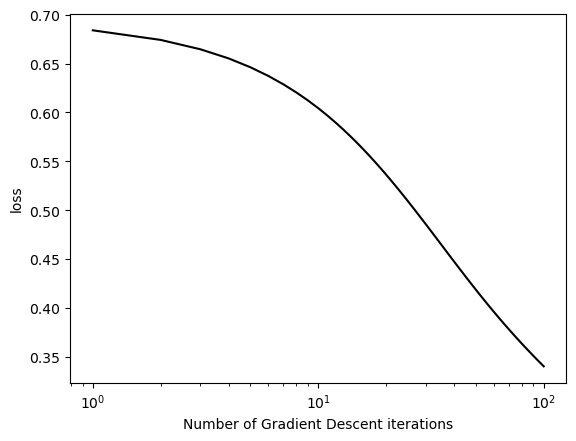

In [481]:
train_and_plot(X_exp, y_exp, 0.1, 0)

### 2. Benefits of momentum: 
On the same data, gradient descent with momentum (e.g. beta = 0.9) can converge to the correct weight vector in fewer iterations than vanilla gradient descent (with beta = 0). Plot the loss over iterations for each method.

We'll use the same data (x_exp, y_exp) to show what simply adding momentum can do. By changing our beta term, it adds a whole new dimension for equation (2) in logistic.py. The equation 
\begin{aligned}
    \mathbf{w}_{k+1} \gets \mathbf{w}_k - \alpha \nabla L(\mathbf{w}_k) + \beta(\mathbf{w}_k - \mathbf{w}_{k-1})
\end{aligned}
will now have a non-zero last term with beta, which incorporates past weights ${w}_{k-1}$ to add momentum.

By including past weights and present weights to calculate future weights, the momentum term helps converge faster, and we can see this by using the train_and_plot function. Again, the only thing we've changed is the beta term from 0 to 0.9

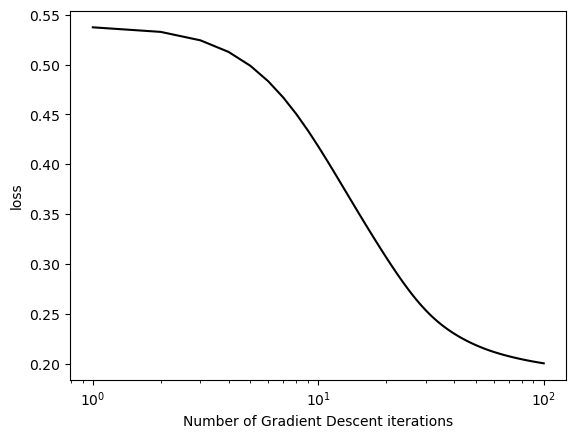

In [482]:
train_and_plot(X_exp, y_exp, 0.1, 0.9)

### Overfitting:
Let's generate some data where p_dim > n_points. We'll do this **twice** with the exact same parameters, the first for a train set and the second for a test set.

In [483]:
points = 200
dims = 1000

X_train, y_train = classification_data(n_points=points, noise=0.5, p_dims=dims)
X_test, y_test = classification_data(n_points=points, noise=0.5, p_dims=dims)


We'll then do an experiment in which we fit a logistic regression model to the data X_train, y_train and obtain 100% accuracy on this training data.

In [484]:
# create our logistic regression and optimizer
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

train_acc = 0

# train until we achieve 100% accuracy :0
while (train_acc != 1):
    
    opt.step(X_train, y_train, 0.1, 0.9)

    # use LogisticRegression.predict method to calculate accuracy
    train_acc = (1.0*(LR.predict(X_train)==y_train)).mean()


print("training accuracy: ", float(train_acc))
print("testing accuracy: ", float((1.0*(LR.predict(X_test) == y_test)).mean()))

training accuracy:  1.0
testing accuracy:  0.7900000214576721


While it depends to a certain degree on the level of noise in the data, we can see that our testing accuracy is considerable lower than training accuracy. This is because using data where the number of features outweighs the number of data points results in overfitting.

Because there are so many features, the logistic regression model will essential memorize the data, rather than generalize from it - this is the way overfitting works. On new test data the model hasn't seen, it isn't as equipped to generalize to these new data points. 

If we use the exact same pipeline, but switch the number of dimensions with the number of data points, we can see our test accuracy skyrocket.

In [485]:
points = 1000
dims = 200

X_train, y_train = classification_data(n_points=points, noise=0.5, p_dims=dims)
X_test, y_test = classification_data(n_points=points, noise=0.5, p_dims=dims)

LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)
train_acc = 0

while (train_acc != 1):
    
    opt.step(X_train, y_train, 0.1, 0.9)
    train_acc = (1.0*(LR.predict(X_train)==y_train)).mean()

print("training accuracy: ", float(train_acc))
print("testing accuracy: ", float((1.0*(LR.predict(X_test) == y_test)).mean()))

training accuracy:  1.0
testing accuracy:  0.9890000224113464


## Discussion

In this blog post, we implemented Logistic Regression and a Gradient Descent with Momentum optimizer. This was a great way to cement my knowledge about logistic regression and learn the intricacies of the loss, grad, and step functions necessary to make these models and training loops work. The experiments showed the effects of momentum (the beta value), the relationship between number of points and number of dimensions, and visualized how Gradient Descent minimizes loss over the iteration cycle. I can now confidently describe the parameters, inner workings, and outputs of Gradient Descent.